## Installation

Useful links:
- https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#protobuf-installation-compilation 
- https://developer.apple.com/forums/thread/688336#:~:text=I%20got%20the%20TensorFlow%20object%20detection%20tutorial%20page
- https://developer.apple.com/forums/thread/700906#:~:text=pip%20install%20/Downloads/tensorflow_text%2D2.8.1%2Dcp38%2Dcp38%2Dmacosx_11_0_arm64.whl
- https://github.com/tensorflow/io/issues/1625#:~:text=Putting%20this%20here%20in%20case%20anybody%20else%20runs%20into%20the%20same%20issue%20I%20had%20with%20using%20conda.%0AI%20finally%20got%20this%20working%20by%20ignoring%20the%20instructions%20here.%20And%20doing%20the%20following%3A

1. brew install protobuf
2. pip install cython
3. pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
4. mkdir TensorFlow.. cd TensorFlow.. git clone git@github.com:tensorflow/models.git
5. cd models/research.. protoc object_detection/protos/*.proto --python_out=.
6. cp object_detection/packages/tf2/setup.py .
7. git clone https://github.com/tensorflow/io.git
8. cd io.. python setup.py -q bdist_wheel --project tensorflow_io_gcs_filesystem
9. pip install --no-deps dist/tensorflow_io_gcs_filesystem-0.26.0-cp39-cp39-macosx_12_0_arm64.whl
10. python setup.py -q bdist_wheel
11. pip install --no-deps dist/tensorflow_io-0.27.0-cp39-cp39-macosx_11_0_arm64.whl 
12. cd models/research.. pip install --no-deps tf-models-official
13. python -m pip install --force --no-dependencies .
14. pip install protobuf==3.20
15. pip install tf_slim


From tutorial:
- https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb

In [13]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import os
import pathlib

%matplotlib inline

In [14]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

Model configurations for tensorflow 2: 
- https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2

In [15]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8',
            'faster_rcnn_resnet50': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'}

model_display_name = 'faster_rcnn_resnet50' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

Model downloads: 
- https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [16]:
'''!mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/'''

'!mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/'

In [17]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

'''if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
elif model_display_name == 'faster_rcnn_resnet50': 
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
  !tar -xf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
  !mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/'''

"if model_display_name == 'centernet_with_keypoints':\n  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz\n  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz\n  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/\nelif model_display_name == 'faster_rcnn_resnet50': \n  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz\n  !tar -xf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz\n  !mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/\nelse:\n  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz\n  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz\n  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/"

In [18]:
pipeline_config = os.path.join(os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/configs/tf2/',
                                 model_name + '.config')
# pipeline_config = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config'
model_dir = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

Label maps not present in config file:
- https://github.com/tensorflow/models/issues/8858#:~:text=In%20the%20above%20example%20you%20are%20encountering%202%20problems.

In [7]:
# label_map_path = configs['eval_input_config'].label_map_path
label_map_path = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


2022-11-16 16:28:40.815737: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-16 16:28:40.815935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 16:28:49.173297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


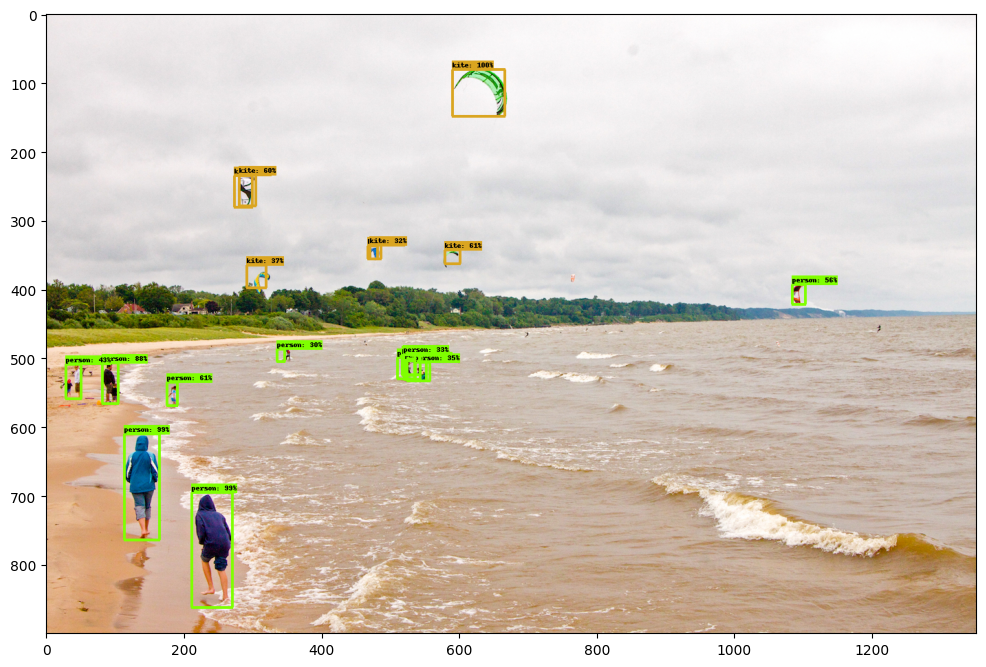

In [9]:
image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

# Testing ART implementation

In [1]:
from art.estimators.object_detection.tensorflow_v2_faster_rcnn import TensorFlowV2FasterRCNN
from art.utils import load_dataset
import tensorflow as tf
import numpy as np

import glob
from six import BytesIO
from PIL import Image

from object_detection.utils import label_map_util

import cv2
import matplotlib
import matplotlib.pyplot as plt
import os

/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/Users/kieranfrase

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)
image_np1 = load_image_into_numpy_array(image_path)
image_np = np.stack([image_np, image_np1])
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-21 16:37:43.269366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 16:37:43.269489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
images = glob.glob(os.path.join(os.getcwd(), "../../../notebooks/adversarial_patch/assets/data/n01440764")+'/*.JPEG')
image_np = load_image_into_numpy_array(images[0])
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)

image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)
image_np1 = load_image_into_numpy_array(image_path)
image_np = np.stack([image_np, image_np1])
input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
#input_tensor = tf.convert_to_tensor(
#    np.expand_dims(image_np, 0), dtype=tf.float32)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-21 11:09:54.132657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 11:09:54.132794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
'''image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)'''

"image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'\nimage_path = os.path.join(image_dir, 'image2.jpg')\nimage_np = load_image_into_numpy_array(image_path)"

In [6]:
# Define object detector
obj_dec = TensorFlowV2FasterRCNN(images=input_tensor)

filename faster_rcnn_resnet50_v1_640x640_coco17_tpu-8
art path /Users/kieranfraser/.art/data
url http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
path /Users/kieranfraser/.art/data/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8


In [7]:
dets = obj_dec.predict(input_tensor, standardise_output=True)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


In [14]:

# label_map_path = configs['eval_input_config'].label_map_path
label_map_path = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

COCO_INSTANCE_CATEGORY_NAMES = list(label_map_dict.keys())

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [category_index[i]['name'] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    # plt.show()

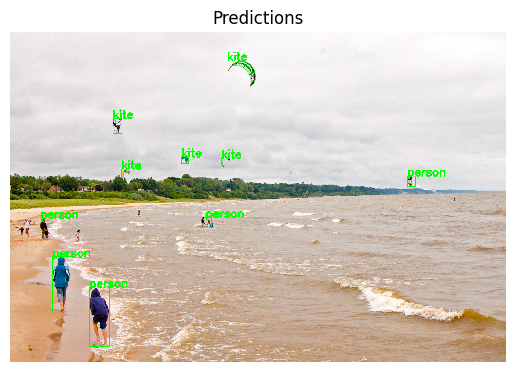

In [15]:
%matplotlib inline
threshold = 0.5
preds = extract_predictions(dets[0], threshold)
plot_image_with_boxes(img=image_np[0], boxes=preds[1], pred_cls=preds[0], title="Predictions")

#### Calculate the gradients

In [10]:
y = [{"boxes": dets[0]["boxes"], "labels": dets[0]["labels"], "scores": np.ones_like(dets[0]["labels"])},
    {"boxes": dets[1]["boxes"], "labels": dets[1]["labels"], "scores": np.ones_like(dets[1]["labels"])}]
# Compute gradients
grads = obj_dec.loss_gradient(input_tensor, y, standardise_output=True)
grads[0][0][0]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.4174582e-07, -4.1617665e-07, -1.7637124e-07], dtype=float32)>

#### Calculate the losses

In [11]:
type(obj_dec.compute_loss(input_tensor, y))

numpy.float32

In [12]:
y = [
    {
        "boxes": dets[0]["boxes"],
        "labels": dets[0]["labels"],
        "scores": np.ones_like(dets[0]["labels"]),
    },
    {
        "boxes": dets[1]["boxes"],
        "labels": dets[1]["labels"],
        "scores": np.ones_like(dets[1]["labels"]),
    },
]

print('total loss:', obj_dec.compute_loss(input_tensor, y))

obj_dec.compute_losses(input_tensor, y)

total loss: 7.1074934


{'Loss/RPNLoss/localization_loss': 2.3140135,
 'Loss/RPNLoss/objectness_loss': 3.841419,
 'Loss/BoxClassifierLoss/localization_loss': 0.17439204,
 'Loss/BoxClassifierLoss/classification_loss': 0.6629907}

#### test different pretrained model

In [13]:

model = TensorFlowV2FasterRCNN(
    input_tensor,
    model=None,
    filename="faster_rcnn_resnet101_v1_640x640_coco17_tpu-8",
    url="http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz",
)

filename faster_rcnn_resnet101_v1_640x640_coco17_tpu-8
art path /Users/kieranfraser/.art/data
url http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
path /Users/kieranfraser/.art/data/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8


In [14]:
dets = model.predict(input_tensor, standardise_output=True)

INFO:tensorflow:depth of additional conv before box predictor: 0


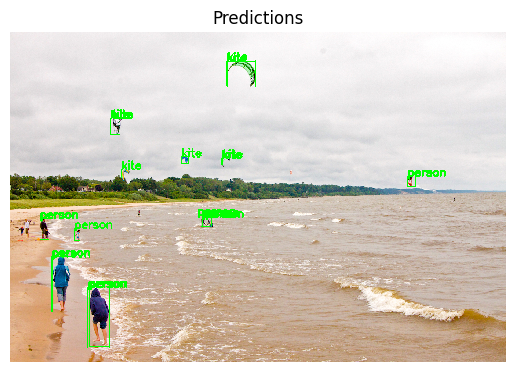

In [15]:
%matplotlib inline
threshold = 0.5
preds = extract_predictions(dets[0], threshold)
plot_image_with_boxes(img=image_np[0], boxes=preds[1], pred_cls=preds[0], title="Predictions")

## Test Attack
RobustDPatch attack applied to tf2 faster rcnn object detection

filename faster_rcnn_resnet101_v1_640x640_coco17_tpu-8
art path /Users/kieranfraser/.art/data
url http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz
path /Users/kieranfraser/.art/data/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8


RobustDPatch iteration:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:tensorflow:depth of additional conv before box predictor: 0


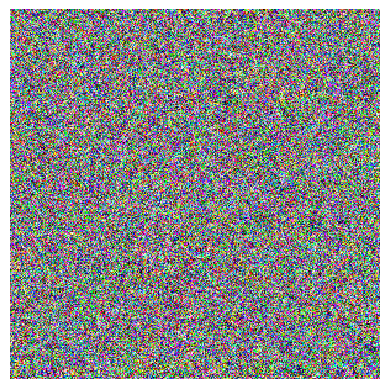

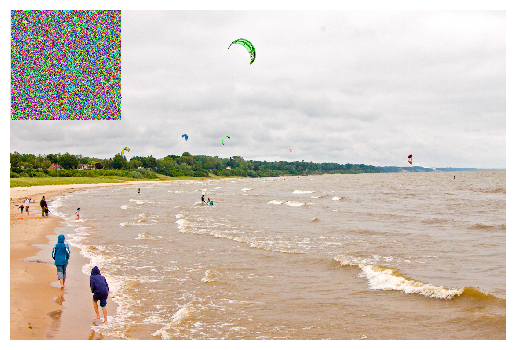

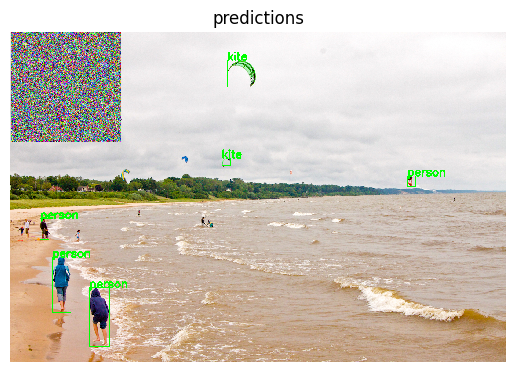

In [18]:
from art.attacks.evasion import RobustDPatch

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [category_index[i]['name'] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 1

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")


image_dir = os.getcwd()+'/../../../TensorFlow/'+'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
img = load_image_into_numpy_array(image_path)
image = np.stack([img]).astype(np.float32)

model = TensorFlowV2FasterRCNN(
    tf.convert_to_tensor(image),
    model=None,
    filename="faster_rcnn_resnet101_v1_640x640_coco17_tpu-8",
    url="http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz",
    clip_values=(0,255), 
    channels_first=False,
)

attack = RobustDPatch(
    model,
    patch_shape=(300,300, 3),
    patch_location=(2, 2),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=50,
    batch_size=1,
    verbose=True,
)

patch = attack.generate(x=image)
patched_image = attack.apply_patch(image)

%matplotlib inline
plt.figure()
plt.axis("off")
plt.imshow(patch.astype(np.uint8), interpolation="nearest")
plt.show()

plt.figure()
plt.axis("off")
plt.imshow(patched_image[0].astype(np.uint8), interpolation="nearest")
plt.show()

dets = model.predict(patched_image, standardise_output=True)
threshold = 0.8
preds = extract_predictions(dets[0], threshold)
plot_image_with_boxes(img=patched_image[0].astype(np.uint8), boxes=preds[1], pred_cls=preds[0], title="predictions")